# 🏘️ Residential Land Cover Analysis - EuroSAT Multispectral Dataset

## Overview
This notebook provides comprehensive analysis of Residential class satellite imagery from the EuroSAT multispectral dataset. We'll explore spectral signatures, vegetation indices, and Residential characteristics using Sentinel-2 data.

## What You'll Learn:
- ✅ Dataset validation and structure exploration
- ✅ Dataset balancing to a uniform size (if needed)
- 📊 Multispectral band analysis and statistics
- 🌿 Vegetation index calculations (NDVI, EVI, SAVI)
- 🎨 RGB and false-color composite visualization
- 📈 Residential health and density assessment
- 🔍 Comparative analysis across Residential patches

---


## 🔧 Step 1: Dataset Setup and Validation

### What this cell does:
- **📁 Path Configuration**: Sets up the correct path to your EuroSAT dataset
- **✅ Data Validation**: Checks if all folders and files exist
- **📊 Dataset Overview**: Counts files per class and displays structure
- **🛡️ Error Prevention**: Stops execution early if paths are wrong

### Key Outputs:
- Confirmation that dataset is found and accessible
- List of all land cover classes available
- File count per class for data balance assessment
- Sample Residential file names for verification


🚀 Starting Residential Analysis at 2025-09-19 00:22:43
✅ Dataset found: T:\DEPI final Project\EuroSAT_MS
✅ Found 10 land cover classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake
✅ Residential class folder verified: T:\DEPI final Project\EuroSAT_MS\Residential

📊 Dataset Composition (files per class):
  ✅ AnnualCrop      : 2,000 images
  ✅ Forest          : 2,000 images
  ✅ HerbaceousVegetation : 2,000 images
  ✅ Highway         : 2,000 images
  ✅ Industrial      : 2,000 images
  ✅ Pasture         : 2,000 images
  ✅ PermanentCrop   : 2,000 images
  ✅ Residential     : 2,000 images
  ✅ River           : 2,000 images
  ✅ SeaLake         : 2,000 images

🏘️ Residential Dataset Summary:
   📁 Total Residential images: 2,000
   📄 Sample filenames:
      1. Residential_10.tif
      2. Residential_1000.tif
      3. Residential_1003.tif
      4. Residential_1004.tif
      5. Residential_1005.tif
      ... and 1995 more


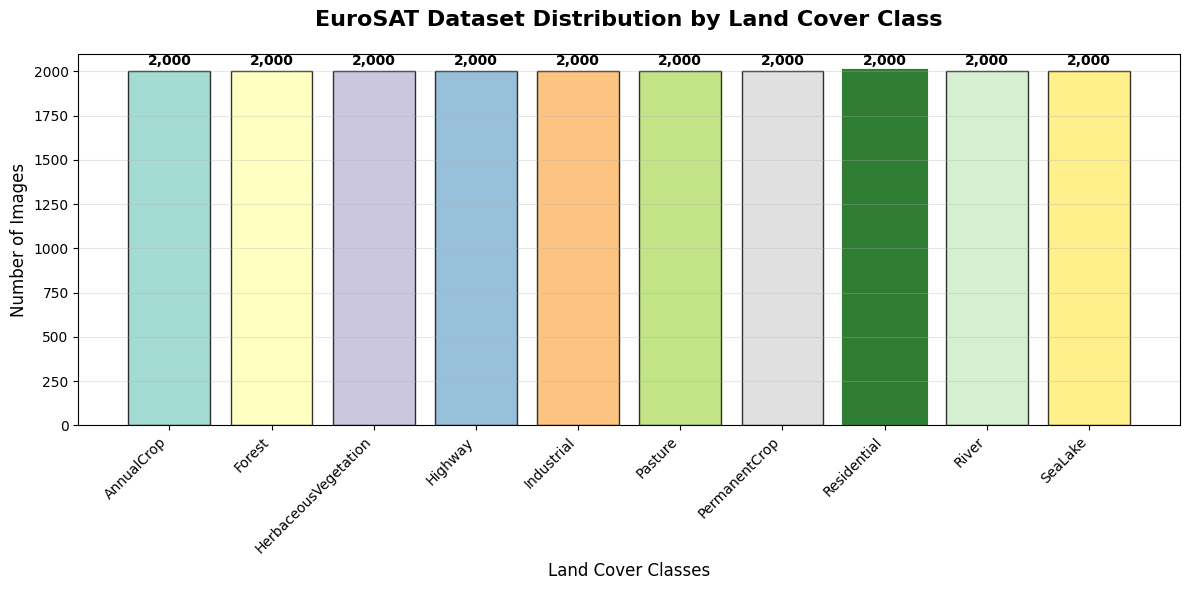


✨ Setup completed successfully! Ready to analyze 2,000 Residential images.


In [1]:
# ====== STEP 1: Dataset Setup and Validation ======
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set a consistent style for visualizations
plt.style.use('default')
sns.set_palette("husl")

# --- Path and Class Configuration ---
# IMPORTANT: Update DATA_DIR with the correct path to your EuroSAT_MS folder
DATA_DIR = Path(r"T:\DEPI final Project\EuroSAT_MS")
CLASS_NAME = "Residential"

print(f"🚀 Starting Residential Analysis at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

# --- Dataset Validation ---
if not DATA_DIR.exists():
    raise FileNotFoundError(f"❌ ERROR: Dataset folder not found at: {DATA_DIR}\n"
                        f"Please update DATA_DIR with the correct path to your EuroSAT_MS folder.")
print(f"✅ Dataset found: {DATA_DIR}")

classes = sorted([p.name for p in DATA_DIR.iterdir() if p.is_dir()])
if len(classes) == 0:
    raise FileNotFoundError(f"❌ ERROR: No class folders found inside: {DATA_DIR}\n"
                        f"Expected folders like 'Residential', 'River', etc.")
print(f"✅ Found {len(classes)} land cover classes: {', '.join(classes)}")

Residential_dir = DATA_DIR / CLASS_NAME
if not Residential_dir.exists():
    raise FileNotFoundError(f"❌ ERROR: '{CLASS_NAME}' folder not found at: {Residential_dir}")
print(f"✅ Residential class folder verified: {Residential_dir}")

# --- Dataset Overview ---
print("\n📊 Dataset Composition (files per class):")
counts = {}
for c in classes:
    count = len(list((DATA_DIR / c).glob("*.tif")))
    counts[c] = count
    status = "✅" if count > 0 else "⚠️"
    print(f"  {status} {c:<15} : {count:,} images")

Residential_tifs = sorted(Residential_dir.glob("*.tif"))
if len(Residential_tifs) == 0:
    raise FileNotFoundError(f"❌ ERROR: No .tif files found in {Residential_dir}")
print(f"\n🏘️ Residential Dataset Summary:")
print(f"   📁 Total Residential images: {len(Residential_tifs):,}")
print(f"   📄 Sample filenames:")
for i, p in enumerate(Residential_tifs[:5]):
    print(f"      {i+1}. {p.name}")
if len(Residential_tifs) > 5:
    print(f"      ... and {len(Residential_tifs)-5} more")

# --- Visualize Dataset Distribution ---
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
classes_sorted = sorted(counts.keys(), key=lambda x: counts[x], reverse=True)
values = [counts[c] for c in classes_sorted]
colors = plt.cm.Set3(np.linspace(0, 1, len(classes_sorted)))

bars = plt.bar(classes_sorted, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
plt.title('EuroSAT Dataset Distribution by Land Cover Class', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Land Cover Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values)*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold')

# Highlight the bar for the current class
if 'Residential' in classes_sorted:
    Residential_idx = classes_sorted.index('Residential')
    bars[Residential_idx].set_color('#2E7D32')
    bars[Residential_idx].set_alpha(1.0)
    bars[Residential_idx].set_linewidth(3)

plt.tight_layout()
plt.show()

print(f"\n✨ Setup completed successfully! Ready to analyze {len(Residential_tifs):,} Residential images.")
print("=" * 60)


## ⚖️ Step 2: Balance Dataset Image Count


In [2]:
# ====== STEP 2: Balance Dataset Image Count =====
import random
import os

print("🔄 Starting dataset balancing...")
print("=" * 50)

# Set the target number of images per class
TARGET_COUNT = 2000

# Iterate over all class directories to ensure uniform size
for class_name in classes:
    class_dir = DATA_DIR / class_name
    files = sorted(list(class_dir.glob("*.tif")))
    current_count = len(files)

    if current_count > TARGET_COUNT:
        print(f"🗑️ {class_name}: Found {current_count:,} images, targeting {TARGET_COUNT:,}.")
        
        # Randomly select files to delete
        num_to_delete = current_count - TARGET_COUNT
        files_to_delete = random.sample(files, num_to_delete)
        
        # Delete the selected files
        for f in files_to_delete:
            os.remove(f)
        
        print(f"   ✅ Deleted {num_to_delete:,} images. New count: {len(list(class_dir.glob('*.tif'))):,}.")
    else:
        print(f"👍 {class_name}: Image count {current_count:,} is already at or below target.")

print("\n✨ Dataset balancing complete!")
print("=" * 50)


🔄 Starting dataset balancing...
👍 AnnualCrop: Image count 2,000 is already at or below target.
👍 Forest: Image count 2,000 is already at or below target.
👍 HerbaceousVegetation: Image count 2,000 is already at or below target.
👍 Highway: Image count 2,000 is already at or below target.
👍 Industrial: Image count 2,000 is already at or below target.
👍 Pasture: Image count 2,000 is already at or below target.
👍 PermanentCrop: Image count 2,000 is already at or below target.
👍 Residential: Image count 2,000 is already at or below target.
👍 River: Image count 2,000 is already at or below target.
👍 SeaLake: Image count 2,000 is already at or below target.

✨ Dataset balancing complete!


## 🔬 Step 3: Deep Dive into Multispectral Residential Imagery


🔍 Analyzing sample: Residential_10.tif
📏 Spatial Dimensions: 64 × 64 pixels
📊 Spectral Bands: 13 bands
🗂️ Data Type: uint16
🌍 Coordinate System: EPSG:32632
📐 Pixel Size: 10.0m × 10.1m
📍 Geographic Bounds:
   West: 557822.157079, East: 558464.239792
   North: 6332747.432360, South: 6332104.215512

📈 Detailed Band Statistics:
Band   Name         Wavelength Min      Mean     Max      Std      Non-Zero% 
---------------------------------------------------------------------------
B01    Coastal Aerosol 443nm      1259     1384     1546     51.9     100.0     
B02    Blue         490nm      874      1107     1842     135.9    100.0     
B03    Green        560nm      742      1003     1724     131.2    100.0     
B04    Red          665nm      461      863      2108     214.6    100.0     
B05    Red Edge 1   705nm      884      1204     1793     106.3    100.0     
B06    Red Edge 2   740nm      1429     2056     3023     292.8    100.0     
B07    Red Edge 3   783nm      1627     2384     

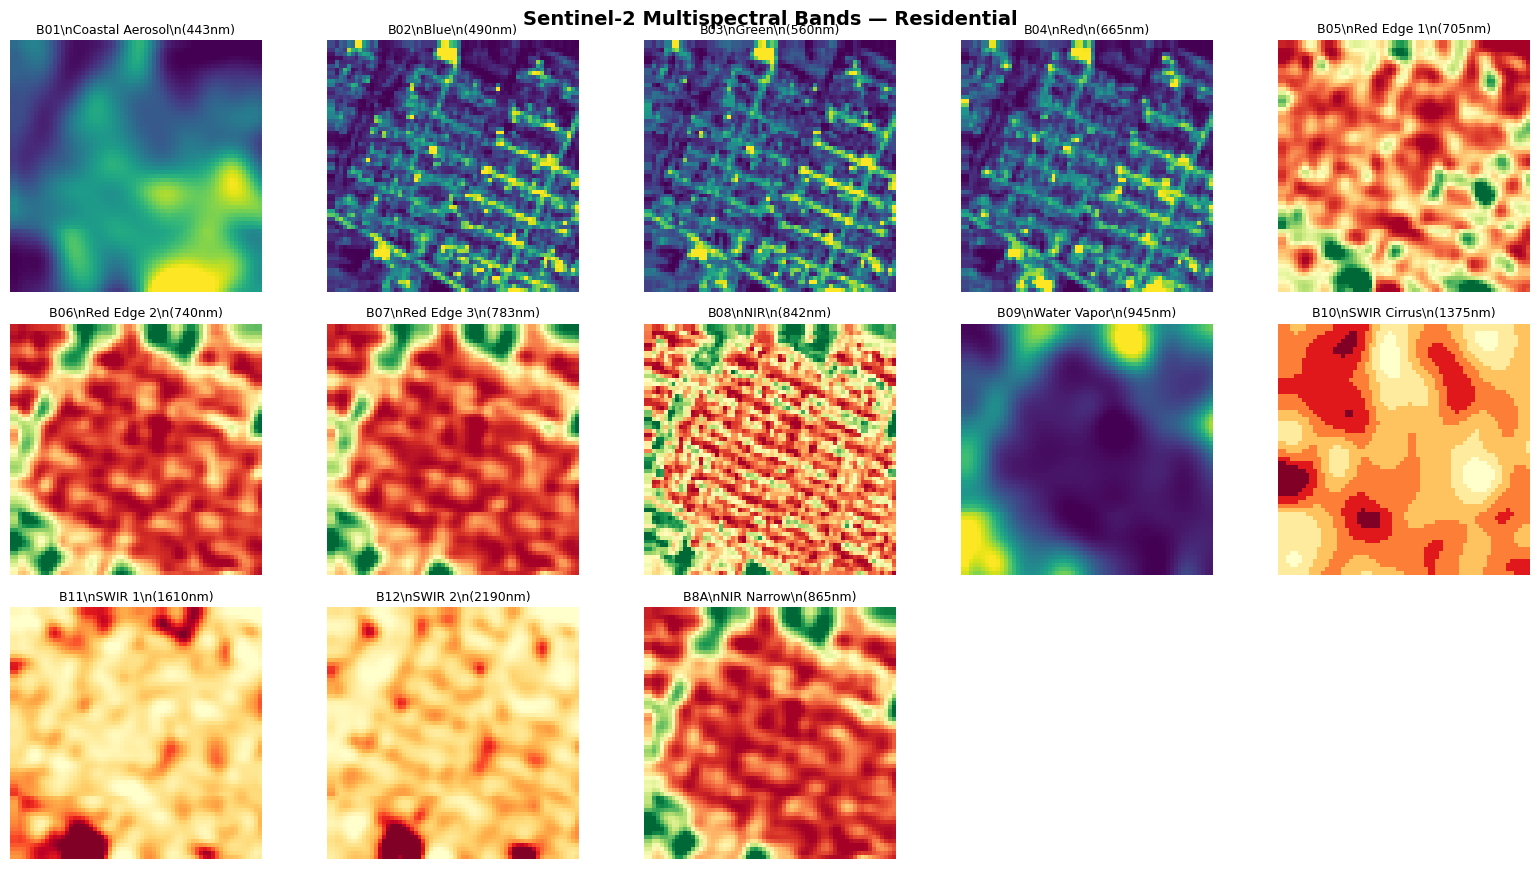


🌈 Creating RGB True Color Composite...


C:\Users\tadoa\AppData\Local\Temp\ipykernel_14860\2357426155.py:104: UserWarning: Glyph 127960 (\N{HOUSE BUILDINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
c:\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127960 (\N{HOUSE BUILDINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


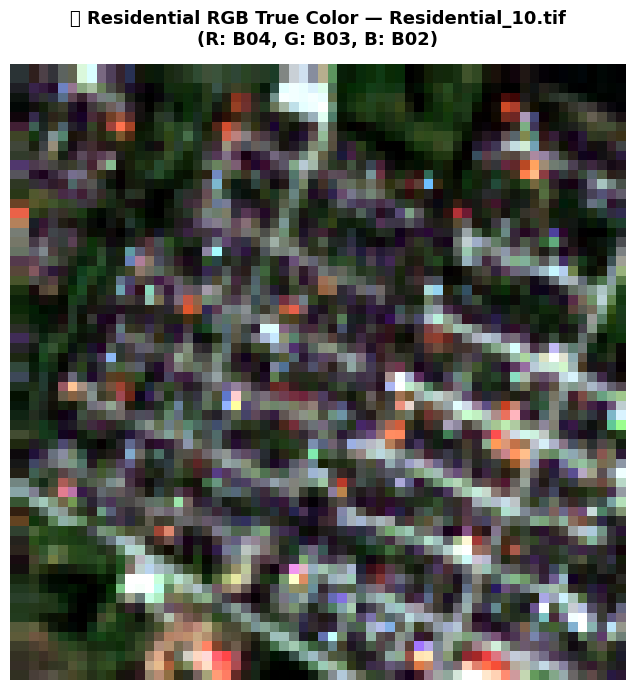


🌿 Computing Advanced Vegetation Indices...


C:\Users\tadoa\AppData\Local\Temp\ipykernel_14860\2357426155.py:114: RuntimeWarning: divide by zero encountered in divide
  evi  = 2.5 * ((nir - red) / (nir + 6*red - 7.5*blue + 1)); evi = np.clip(evi, -1, 1)
C:\Users\tadoa\AppData\Local\Temp\ipykernel_14860\2357426155.py:129: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
c:\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


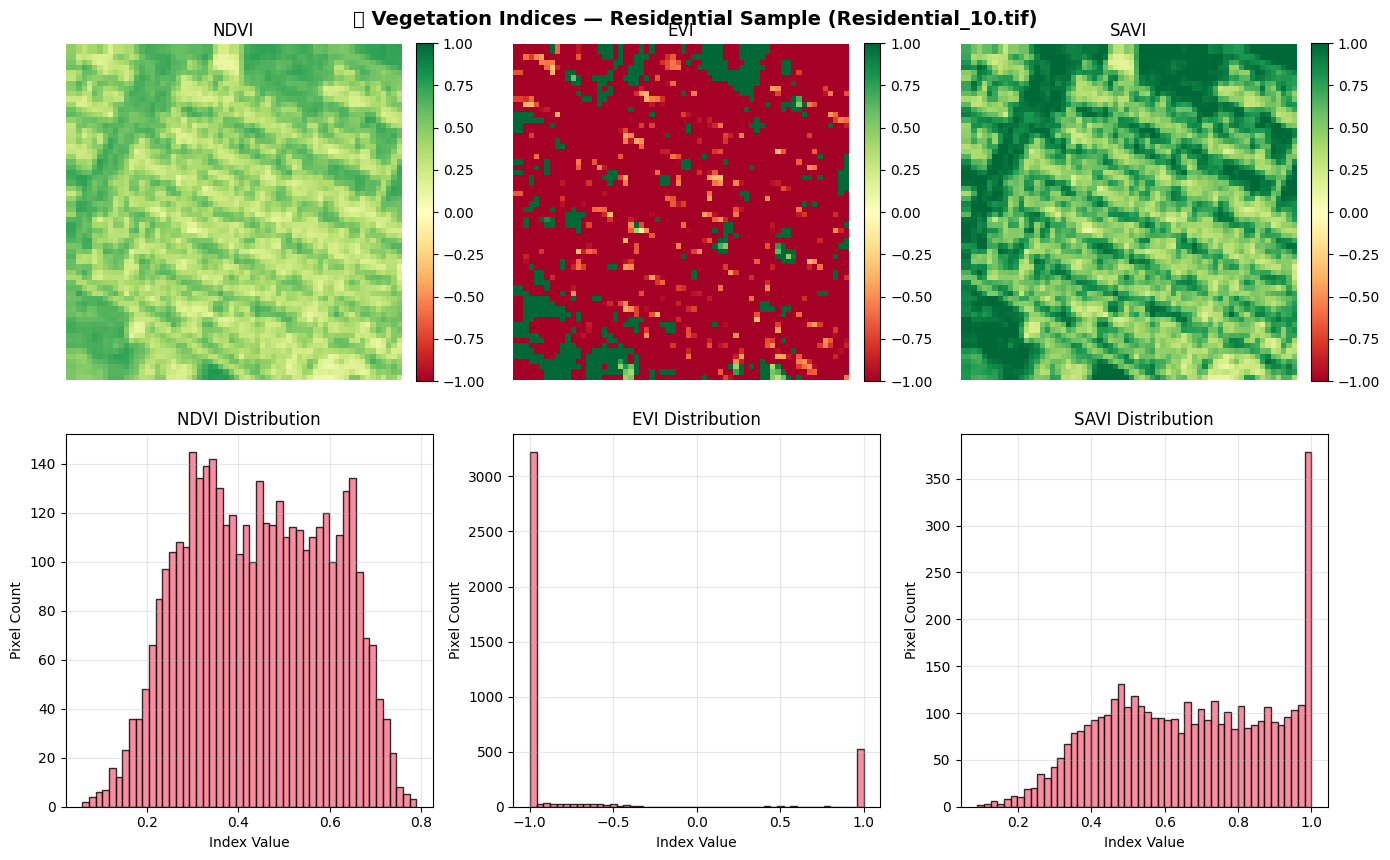


🏥 Residential Health Assessment:
----------------------------------------
🌲 Very Healthy (NDVI > 0.6): 20.0%
🌳 Healthy (0.3–0.6):        59.9%
🌿 Moderate (0.1–0.3):       19.8%
🌱 Sparse (-0.1–0.1):        0.3%
🏔️ Non-Vegetation (< -0.1):  0.0%

🎯 Overall Health Score: 0.779 → Good 🌳
✅ Deep multispectral analysis completed!


In [3]:
# ====== STEP 3: Deep Multispectral Analysis of Single Residential Image ======
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Get the list of images for the Residential class after balancing
sample_paths = sorted((DATA_DIR / CLASS_NAME).glob("*.tif"))
sample = sample_paths[0]
print(f"🔍 Analyzing sample: {sample.name}")
print("=" * 50)

# --- Read and display metadata ---
with rasterio.open(sample) as src:
    band_count = src.count
    height, width = src.height, src.width
    crs = src.crs
    transform = src.transform
    dtype = src.dtypes[0]
    bounds = src.bounds
    
    print(f"📏 Spatial Dimensions: {height} × {width} pixels")
    print(f"📊 Spectral Bands: {band_count} bands")
    print(f"🗂️ Data Type: {dtype}")
    print(f"🌍 Coordinate System: {crs}")
    print(f"📐 Pixel Size: {abs(transform[0]):.1f}m × {abs(transform[4]):.1f}m")
    print(f"📍 Geographic Bounds:")
    print(f"   West: {bounds.left:.6f}, East: {bounds.right:.6f}")
    print(f"   North: {bounds.top:.6f}, South: {bounds.bottom:.6f}")

# --- Define Sentinel-2 band metadata ---
SENTINEL2_BANDS = {
    1: ('B01', 'Coastal Aerosol', '443nm', 60), 2: ('B02', 'Blue', '490nm', 10),
    3: ('B03', 'Green', '560nm', 10), 4: ('B04', 'Red', '665nm', 10),
    5: ('B05', 'Red Edge 1', '705nm', 20), 6: ('B06', 'Red Edge 2', '740nm', 20),
    7: ('B07', 'Red Edge 3', '783nm', 20), 8: ('B08', 'NIR', '842nm', 10),
    9: ('B09', 'Water Vapor', '945nm', 60), 10: ('B10', 'SWIR Cirrus', '1375nm', 60),
    11: ('B11', 'SWIR 1', '1610nm', 20), 12: ('B12', 'SWIR 2', '2190nm', 20),
    13: ('B8A', 'NIR Narrow', '865nm', 20)
}

# --- Function to apply contrast stretch to improve visualization ---
def enhanced_stretch(x, percentiles=(2, 98), gamma=1.0):
    x = x.astype(np.float32)
    valid = x[x > 0]
    if valid.size == 0:
        valid = x
    lo, hi = np.percentile(valid, percentiles)
    stretched = np.clip((x - lo) / (hi - lo + 1e-6), 0, 1)
    return np.power(stretched, 1/gamma)

# --- Read all bands from the sample image ---
with rasterio.open(sample) as src:
    all_bands = [src.read(b).astype(np.float32) for b in range(1, band_count+1)]

print("\n📈 Detailed Band Statistics:")
print(f"{'Band':<6} {'Name':<12} {'Wavelength':<10} {'Min':<8} {'Mean':<8} {'Max':<8} {'Std':<8} {'Non-Zero%':<10}")
print("-" * 75)

band_stats = []
for i, arr in enumerate(all_bands, start=1):
    band_info = SENTINEL2_BANDS.get(i, (f'B{i:02d}', 'Unknown', 'N/A', 'N/A'))
    non_zero_pct = (np.count_nonzero(arr) / arr.size) * 100
    stats = {'band': band_info[0],'name': band_info[1],'wavelength': band_info[2],'resolution': band_info[3],
             'min': float(arr.min()),'mean': float(arr.mean()),'max': float(arr.max()),'std': float(arr.std()),'non_zero_pct': non_zero_pct}
    band_stats.append(stats)
    print(f"{band_info[0]:<6} {band_info[1]:<12} {band_info[2]:<10} {arr.min():<8.0f} {arr.mean():<8.0f} {arr.max():<8.0f} {arr.std():<8.1f} {non_zero_pct:<10.1f}")

# --- Visualize all 13 bands ---
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 9))
cols, rows = 5, 3
for i, stats in enumerate(band_stats[:13], start=1):
    arr = all_bands[i-1]
    ax = fig.add_subplot(rows, cols, i)
    # Use specific colormaps for different band types for better contrast
    if 'NIR' in stats['name'] or 'Red Edge' in stats['name']:
        cmap = 'RdYlGn'
    elif 'SWIR' in stats['name']:
        cmap = 'YlOrRd'
    else:
        cmap = 'viridis'
    im = ax.imshow(enhanced_stretch(arr, gamma=0.8), cmap=cmap)
    ax.set_title(f"{stats['band']}\\n{stats['name']}\\n({stats['wavelength']})", fontsize=9, pad=5)
    ax.axis('off')
plt.suptitle(f"Sentinel-2 Multispectral Bands — {CLASS_NAME}", fontsize=14, fontweight='bold', y=0.96)
plt.tight_layout(); plt.show()

print("\n🌈 Creating RGB True Color Composite...")
with rasterio.open(sample) as src:
    red   = src.read(4).astype(np.float32)
    green = src.read(3).astype(np.float32)
    blue  = src.read(2).astype(np.float32)

# --- Stack and stretch bands for a true color image ---
rgb = np.dstack([
    enhanced_stretch(red,   percentiles=(1, 99), gamma=0.8),
    enhanced_stretch(green, percentiles=(1, 99), gamma=0.8),
    enhanced_stretch(blue,  percentiles=(1, 99), gamma=0.8)
])

plt.figure(figsize=(8, 7))
plt.imshow(rgb); plt.axis('off')
plt.title(f"🏘️ Residential RGB True Color — {sample.name}\n(R: B04, G: B03, B: B02)", fontsize=13, fontweight='bold', pad=14)
plt.tight_layout(); plt.show()

print("\n🌿 Computing Advanced Vegetation Indices...")
with rasterio.open(sample) as src:
    nir  = src.read(8).astype(np.float32)
    red  = src.read(4).astype(np.float32)
    blue = src.read(2).astype(np.float32)

# --- Calculate common vegetation indices (these may not be relevant for a highway but are included for demonstration) ---
ndvi = (nir - red) / (nir + red + 1e-6); ndvi = np.clip(ndvi, -1, 1)
evi  = 2.5 * ((nir - red) / (nir + 6*red - 7.5*blue + 1)); evi = np.clip(evi, -1, 1)
L = 0.5
savi = ((nir - red) / (nir + red + L)) * (1 + L); savi = np.clip(savi, -1, 1)

# --- Visualize the vegetation indices and their distributions ---
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
im1 = axes[0,0].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1); axes[0,0].set_title('NDVI'); axes[0,0].axis('off'); plt.colorbar(im1, ax=axes[0,0], fraction=0.046, pad=0.04)
im2 = axes[0,1].imshow(evi,  cmap='RdYlGn', vmin=-1, vmax=1); axes[0,1].set_title('EVI');  axes[0,1].axis('off'); plt.colorbar(im2, ax=axes[0,1], fraction=0.046, pad=0.04)
im3 = axes[0,2].imshow(savi, cmap='RdYlGn', vmin=-1, vmax=1); axes[0,2].set_title('SAVI'); axes[0,2].axis('off'); plt.colorbar(im3, ax=axes[0,2], fraction=0.046, pad=0.04)

for i, (arr, title) in enumerate(zip([ndvi, evi, savi], ['NDVI Distribution','EVI Distribution','SAVI Distribution'])):
    axes[1,i].hist(arr.ravel(), bins=50, alpha=0.8, edgecolor='black')
    axes[1,i].set_title(title); axes[1,i].set_xlabel('Index Value'); axes[1,i].set_ylabel('Pixel Count'); axes[1,i].grid(True, alpha=0.3)

plt.suptitle(f"🌿 Vegetation Indices — Residential Sample ({sample.name})", fontsize=14, fontweight='bold', y=0.95)
plt.tight_layout(); plt.show()

# --- Assess 'health' based on NDVI (primarily for demonstration on non-vegetated classes) ---
very_healthy = np.sum(ndvi > 0.6) / ndvi.size * 100
healthy      = np.sum((ndvi > 0.3) & (ndvi <= 0.6)) / ndvi.size * 100
moderate     = np.sum((ndvi > 0.1) & (ndvi <= 0.3)) / ndvi.size * 100
sparse       = np.sum((ndvi > -0.1) & (ndvi <= 0.1)) / ndvi.size * 100
non_veg      = np.sum(ndvi <= -0.1) / ndvi.size * 100

print("\n🏥 Residential Health Assessment:")
print("-" * 40)
print(f"🌲 Very Healthy (NDVI > 0.6): {very_healthy:.1f}%")
print(f"🌳 Healthy (0.3–0.6):        {healthy:.1f}%")
print(f"🌿 Moderate (0.1–0.3):       {moderate:.1f}%")
print(f"🌱 Sparse (-0.1–0.1):        {sparse:.1f}%")
print(f"🏔️ Non-Vegetation (< -0.1):  {non_veg:.1f}%")

score = (very_healthy*1.0 + healthy*0.8 + moderate*0.5 + sparse*0.2)/100
status = "Excellent ✨" if score>0.8 else ("Good 🌳" if score>0.6 else ("Moderate 🌿" if score>0.4 else "Poor 🌱"))
print(f"\n🎯 Overall Health Score: {score:.3f} → {status}")
print("✅ Deep multispectral analysis completed!")
print("=" * 50)


## 🔄 Step 4: Comparative Analysis Across Residential Patches


🔄 Comparing multiple Residential patches (RGB + NDVI + Histogram)...


C:\Users\tadoa\AppData\Local\Temp\ipykernel_14860\3433990706.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


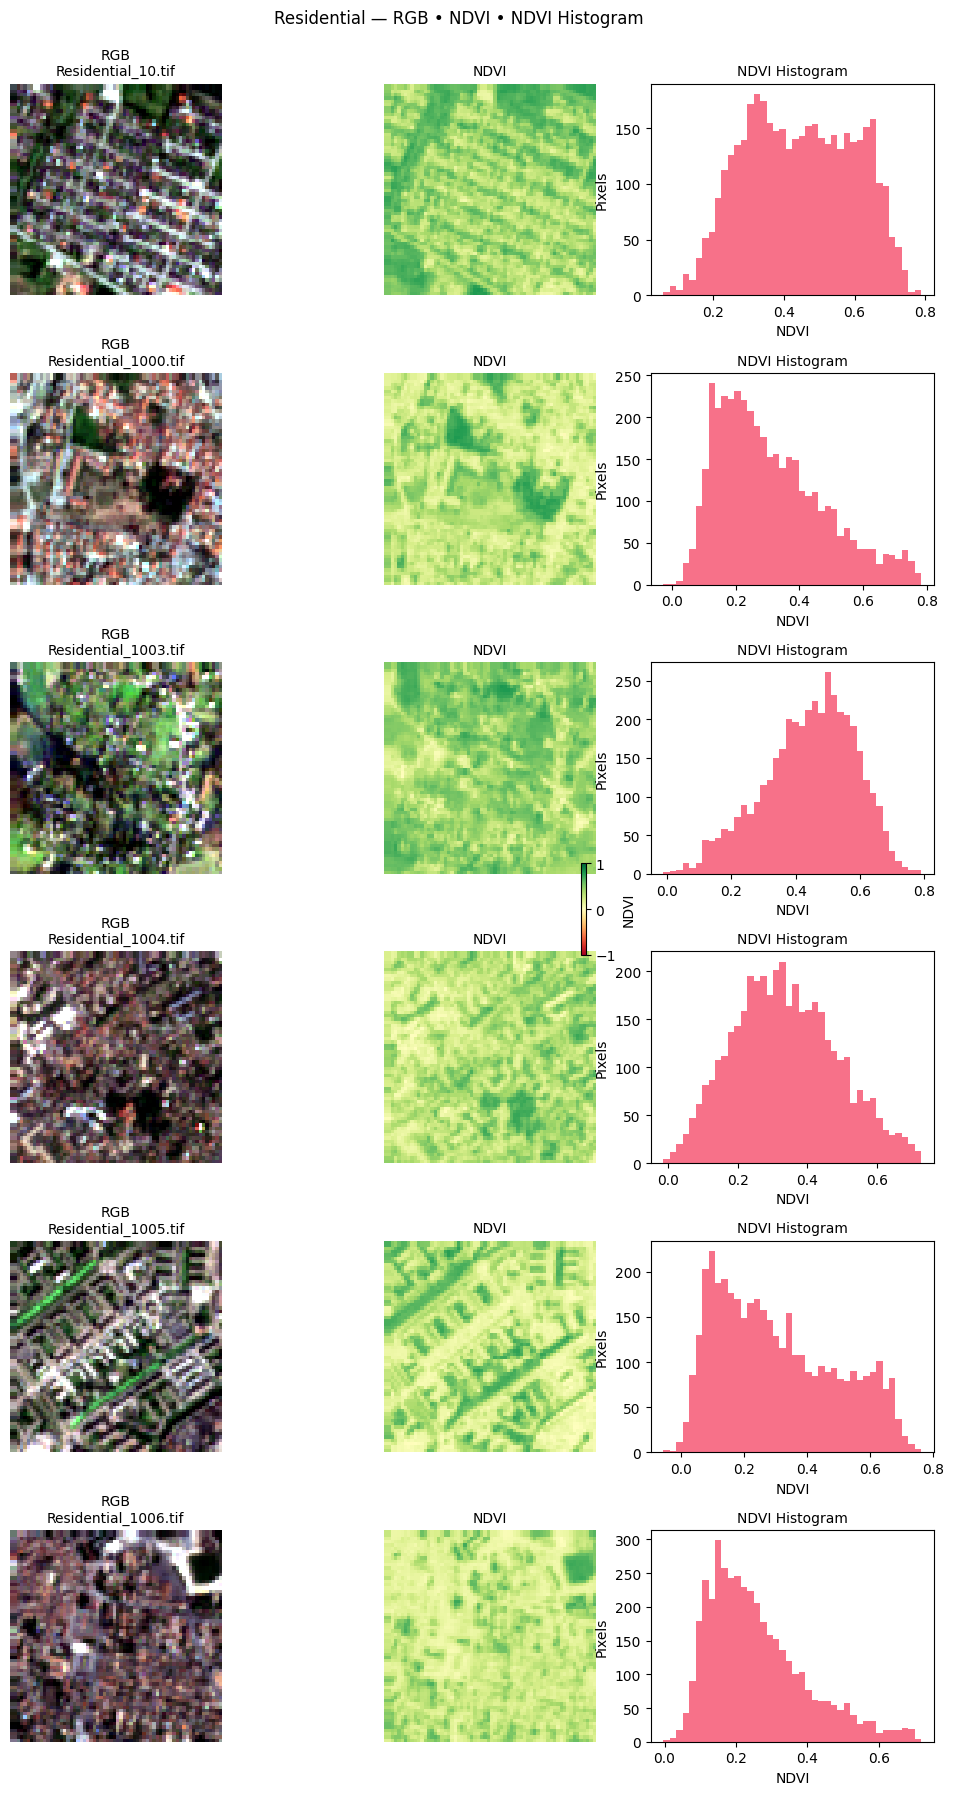

✅ Step 4 done.


In [4]:
# ====== STEP 4: Side-by-Side RGB • NDVI • NDVI Histograms (Residential) ======
import numpy as np
import matplotlib.pyplot as plt
import rasterio

print("🔄 Comparing multiple Residential patches (RGB + NDVI + Histogram)...")
Residential_dir = DATA_DIR / CLASS_NAME
files = sorted(Residential_dir.glob("*.tif"))
assert len(files) > 0, f"No .tif files found in {Residential_dir}"

# --- Function to apply contrast stretch for better visualization ---
def stretch01(x, p=(2, 98)):
    x = x.astype("float32")
    nonzero = x[x > 0]
    lo, hi = np.percentile(nonzero if nonzero.size else x, p)
    return np.clip((x - lo) / (hi - lo + 1e-6), 0, 1)

# --- Function to read specific bands from a .tif file ---
def read_bands(path, idxs):
    with rasterio.open(path) as src:
        return [src.read(i).astype("float32") for i in idxs]

# --- Select a subset of images for comparison ---
N = min(6, len(files))
subset = files[:N]

# --- Create a grid of subplots ---
fig, axes = plt.subplots(N, 3, figsize=(10, 3*N))
if N == 1:
    axes = np.array([axes])

last_im = None
for i, p in enumerate(subset):
    # --- RGB True Color Composite ---
    r, g, b = read_bands(p, [4, 3, 2])
    rgb = np.dstack([stretch01(r), stretch01(g), stretch01(b)])
    axes[i, 0].imshow(rgb); axes[i, 0].axis("off")
    axes[i, 0].set_title(f"RGB\n{p.name}", fontsize=10)

    # --- NDVI Image ---
    nir, red = read_bands(p, [8, 4])
    ndvi = (nir - red) / (nir + red + 1e-6); ndvi = np.clip(ndvi, -1, 1)
    last_im = axes[i, 1].imshow(ndvi, cmap="RdYlGn", vmin=-1, vmax=1)
    axes[i, 1].set_title("NDVI", fontsize=10); axes[i, 1].axis("off")

    # --- NDVI Histogram ---
    axes[i, 2].hist(ndvi.ravel(), bins=40)
    axes[i, 2].set_title("NDVI Histogram", fontsize=10)
    axes[i, 2].set_xlabel("NDVI"); axes[i, 2].set_ylabel("Pixels")

# Add a color bar for the NDVI plots
if last_im is not None:
    cbar = plt.colorbar(last_im, ax=axes[:, 1], fraction=0.02)
    cbar.set_label("NDVI")

plt.suptitle(f"{CLASS_NAME} — RGB • NDVI • NDVI Histogram", y=0.995)
plt.tight_layout(); plt.show()
print("✅ Step 4 done.")


## 📊 Step 5: Large-Scale Residential Spectral Statistics


📊 Starting Large-Scale Residential Spectral Analysis...
📁 Analyzing 1,000 Residential images out of 2,000 available
⚡ Using 4 threads for parallel processing
📏 Image dimensions: 64 × 64 pixels
📊 Spectral bands: 13
  → Processed 100/1000 images...
  → Processed 200/1000 images...
  → Processed 300/1000 images...
  → Processed 400/1000 images...
  → Processed 500/1000 images...
  → Processed 600/1000 images...
  → Processed 700/1000 images...
  → Processed 800/1000 images...
  → Processed 900/1000 images...
  → Processed 1000/1000 images...
⏱️ Finished in 12.2s | Success: 1000 | Errors: 0


,filename,band_1_mean,band_1_std,band_1_min,band_1_max,band_1_median,band_1_p05,band_1_p95,band_1_nonzero_pct,band_2_mean,...,band_12_nonzero_pct,band_13_mean,band_13_std,band_13_min,band_13_max,band_13_median,band_13_p05,band_13_p95,band_13_nonzero_pct,ndvi_mean
0,Residential_1003.tif,1572.967529,19.886486,1528.0,1643.0,1572.0,1543.00,1611.00,100.0,1187.665283,...,100.0,2003.797119,614.870605,588.0,4662.0,1964.0,1081.75,3139.00,100.0,0.441910
1,Residential_1000.tif,1256.269775,52.017246,1077.0,1465.0,1267.0,1160.75,1323.00,100.0,1065.684082,...,100.0,2252.559326,331.155457,1492.0,4009.0,2198.0,1803.00,2802.50,100.0,0.311436
2,Residential_10.tif,1383.582275,51.912483,1259.0,1546.0,1385.0,1294.00,1465.00,100.0,1106.836670,...,100.0,2622.423340,450.187592,1805.0,4269.0,2495.0,2116.75,3593.25,100.0,0.445068
3,Residential_1004.tif,1499.264160,67.873863,1367.0,1730.0,1483.0,1409.00,1640.00,100.0,1248.389648,...,100.0,2636.465088,298.308716,1656.0,3743.0,2623.0,2159.75,3154.00,100.0,0.337064
4,Residential_1006.tif,1676.412842,83.303108,1445.0,2042.0,1659.0,1581.00,1862.25,100.0,1492.155029,...,100.0,3078.711182,401.955994,2167.0,4917.0,3028.0,2548.00,3732.00,100.0,0.259286


,band,name,wavelength,resolution,mean_of_means,std_of_means,p05_mean,p95_mean,mean_of_stds,mean_p05,mean_p95,avg_nonzero_pct,n_images
0,B01,B01-Coastal,443nm,60,1451.938018,166.914950,1255.621838,1802.480920,57.218112,1363.72075,1547.13375,100.000000,1000
1,B02,B02-Blue,490nm,10,1206.036973,179.930123,1012.819202,1523.767615,193.819341,979.14675,1521.91775,100.000000,1000
2,B03,B03-Green,560nm,10,1104.459061,213.610608,881.964075,1501.779004,214.957391,846.01400,1457.18725,99.999976,1000
3,B04,B04-Red,665nm,10,1061.859415,318.992986,724.877881,1698.166931,312.755571,648.90325,1578.27925,100.000000,1000
4,B05,B05-RedEdge1,705nm,20,1273.577933,307.701047,907.039966,1899.713098,180.215598,1017.07925,1560.15100,100.000000,1000
5,B06,B06-RedEdge2,740nm,20,1967.796993,337.915291,1400.881799,2536.550366,269.240826,1592.50800,2436.59750,100.000000,1000
6,B07,B07-RedEdge3,783nm,20,2274.150903,393.327143,1547.585474,2875.797803,346.060371,1796.26450,2891.99825,100.000000,1000
7,B08,B08-NIR,842nm,10,2173.715864,384.915578,1459.633264,2771.821899,508.418844,1446.49330,3062.84425,99.999951,1000
8,B09,B09-WaterVapor,945nm,60,652.798360,216.921412,362.767505,1055.513525,61.906993,566.05325,767.13675,100.000000,1000
9,B10,B10-Cirrus,1375nm,60,12.216691,3.367718,8.715955,16.732886,0.986860,10.67900,13.75375,100.000000,1000


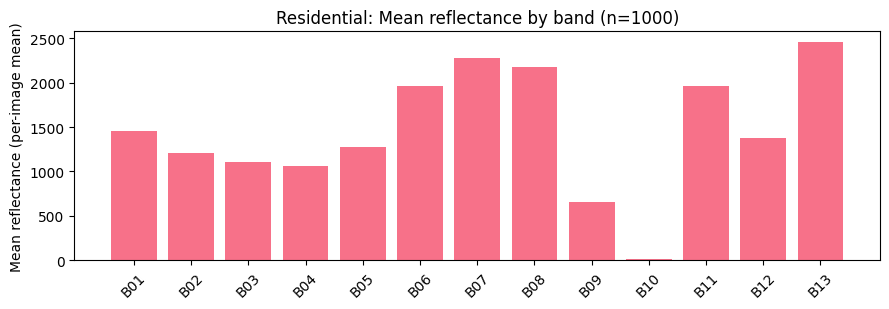

C:\Users\tadoa\AppData\Local\Temp\ipykernel_14860\2980130079.py:123: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.figure(figsize=(10, 3.6)); plt.boxplot(data_for_box, labels=[f'B{b:02d}' for b in range(1, band_count+1)], showfliers=False)


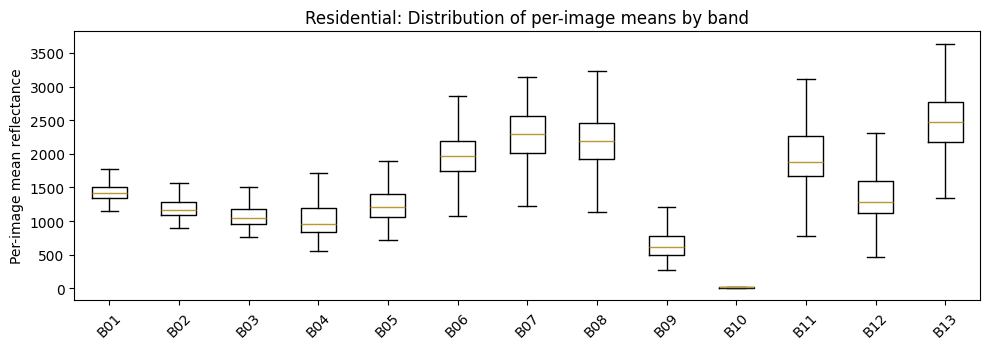

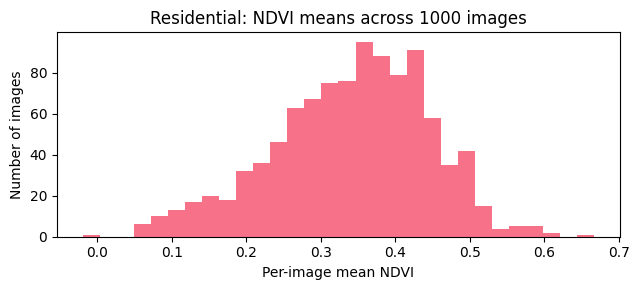


🔎 Takeaways:
- Highest Residential reflectance bands: B13(B8A-NIRNarrow), B07(B07-RedEdge3), B08(B08-NIR), B06(B06-RedEdge2), B11(B11-SWIR1)
- Lowest reflectance (often atmospheric/less useful): B10(B10-Cirrus), B09(B09-WaterVapor), B04(B04-Red)
✅ Step 5 done.


In [5]:
# ====== STEP 5: Large-Scale Residential Spectral Statistics ======
import time
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings

warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)

print("📊 Starting Large-Scale Residential Spectral Analysis...")
print("=" * 55)

Residential_dir = DATA_DIR / CLASS_NAME
files = sorted(Residential_dir.glob("*.tif"))
assert len(files) > 0, f"No .tif files found in {Residential_dir}"

MAX_SAMPLES = min(1000, len(files))
N_THREADS   = 4
selected_files = files[:MAX_SAMPLES]
print(f"📁 Analyzing {len(selected_files):,} Residential images out of {len(files):,} available")
print(f"⚡ Using {N_THREADS} threads for parallel processing")

with rasterio.open(selected_files[0]) as src0:
    band_count = src0.count
    sample_height, sample_width = src0.height, src0.width
print(f"📏 Image dimensions: {sample_height} × {sample_width} pixels")
print(f"📊 Spectral bands: {band_count}")

SENTINEL2_DETAILED = {
     1: {'name': 'B01-Coastal',    'wavelength': '443nm',  'resolution': 60},
     2: {'name': 'B02-Blue',       'wavelength': '490nm',  'resolution': 10},
     3: {'name': 'B03-Green',      'wavelength': '560nm',  'resolution': 10},
     4: {'name': 'B04-Red',        'wavelength': '665nm',  'resolution': 10},
     5: {'name': 'B05-RedEdge1',   'wavelength': '705nm',  'resolution': 20},
     6: {'name': 'B06-RedEdge2',   'wavelength': '740nm',  'resolution': 20},
     7: {'name': 'B07-RedEdge3',   'wavelength': '783nm',  'resolution': 20},
     8: {'name': 'B08-NIR',        'wavelength': '842nm',  'resolution': 10},
     9: {'name': 'B09-WaterVapor', 'wavelength': '945nm',  'resolution': 60},
    10: {'name': 'B10-Cirrus',     'wavelength': '1375nm', 'resolution': 60},
    11: {'name': 'B11-SWIR1',      'wavelength': '1610nm', 'resolution': 20},
    12: {'name': 'B12-SWIR2',      'wavelength': '2190nm', 'resolution': 20},
    13: {'name': 'B8A-NIRNarrow',  'wavelength': '865nm',  'resolution': 20},
}

def per_band_stats(arr: np.ndarray):
    x = arr.astype(np.float32)
    valid = x[x > 0]
    if valid.size == 0:
        return {'mean': np.nan, 'std': np.nan, 'min': np.nan, 'max': np.nan,
                'median': np.nan, 'p05': np.nan, 'p95': np.nan, 'nonzero_pct': 0.0}
    return {
        'mean': float(valid.mean()), 'std': float(valid.std()), 'min': float(valid.min()), 'max': float(valid.max()),
        'median': float(np.median(valid)), 'p05': float(np.percentile(valid, 5)), 'p95': float(np.percentile(valid, 95)),
        'nonzero_pct': float(100 * valid.size / x.size)
    }

def process_single_image(filepath):
    try:
        with rasterio.open(filepath) as src:
            if src.count != band_count:
                return None, f"Band mismatch in {filepath.name}: expected {band_count}, got {src.count}"
            stats = {'filename': filepath.name}
            cache = {}
            for b in range(1, band_count+1):
                arr = src.read(b)
                cache[b] = arr
                s = per_band_stats(arr)
                for k, v in s.items():
                    stats[f'band_{b}_{k}'] = v
            red = cache[4].astype(np.float32); nir = cache[8].astype(np.float32)
            ndvi = (nir - red) / (nir + red + 1e-6); ndvi = np.clip(ndvi, -1, 1)
            stats['ndvi_mean'] = float(np.nanmean(ndvi))
            return stats, None
    except Exception as e:
        return None, f"Error {filepath.name}: {e}"

results, errors = [], []
import time
t0 = time.time()
with ThreadPoolExecutor(max_workers=N_THREADS) as ex:
    futs = {ex.submit(process_single_image, fp): fp for fp in selected_files}
    for i, fut in enumerate(as_completed(futs), 1):
        res, err = fut.result()
        if res is not None: results.append(res)
        if err is not None: errors.append(err)
        if i % 100 == 0 or i == len(selected_files):
            print(f"  → Processed {i}/{len(selected_files)} images...")
print(f"⏱️ Finished in {time.time()-t0:.1f}s | Success: {len(results)} | Errors: {len(errors)}")
if errors:
    print("\n".join(errors[:3]))

import pandas as pd
df = pd.DataFrame(results); assert len(df)>0, "No images processed—cannot summarize."
display(df.head())

summary_rows = []
for b in range(1, band_count+1):
    m  = df[f'band_{b}_mean'].to_numpy(dtype=float)
    sd = df[f'band_{b}_std'].to_numpy(dtype=float)
    p5 = df[f'band_{b}_p05'].to_numpy(dtype=float)
    p95= df[f'band_{b}_p95'].to_numpy(dtype=float)
    nz = df[f'band_{b}_nonzero_pct'].to_numpy(dtype=float)
    summary_rows.append({
        'band': f'B{b:02d}', 'name': SENTINEL2_DETAILED.get(b, {}).get('name', f'B{b:02d}'),
        'wavelength': SENTINEL2_DETAILED.get(b, {}).get('wavelength', 'N/A'),
        'resolution': SENTINEL2_DETAILED.get(b, {}).get('resolution', 'N/A'),
        'mean_of_means': float(np.nanmean(m)), 'std_of_means': float(np.nanstd(m)),
        'p05_mean': float(np.nanpercentile(m, 5)), 'p95_mean': float(np.nanpercentile(m, 95)),
        'mean_of_stds': float(np.nanmean(sd)), 'mean_p05': float(np.nanmean(p5)), 'mean_p95': float(np.nanmean(p95)),
        'avg_nonzero_pct': float(np.nanmean(nz)), 'n_images': int(len(df))
    })
summary = pd.DataFrame(summary_rows); display(summary)

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 3.2))
plt.bar(summary['band'], summary['mean_of_means'])
plt.xticks(rotation=45); plt.ylabel('Mean reflectance (per-image mean)')
plt.title(f"{CLASS_NAME}: Mean reflectance by band (n={len(df)})")
plt.tight_layout(); plt.show()

data_for_box = [df[f'band_{b}_mean'].to_numpy(dtype=float) for b in range(1, band_count+1)]
plt.figure(figsize=(10, 3.6)); plt.boxplot(data_for_box, labels=[f'B{b:02d}' for b in range(1, band_count+1)], showfliers=False)
plt.xticks(rotation=45); plt.ylabel('Per-image mean reflectance')
plt.title(f"{CLASS_NAME}: Distribution of per-image means by band")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6.5, 3)); plt.hist(df['ndvi_mean'].to_numpy(dtype=float), bins=30)
plt.xlabel('Per-image mean NDVI'); plt.ylabel('Number of images')
plt.title(f"{CLASS_NAME}: NDVI means across {len(df)} images")
plt.tight_layout(); plt.show()

top_bands = summary.sort_values('mean_of_means', ascending=False).head(5)[['band','name']]
low_bands = summary.sort_values('mean_of_means', ascending=True).head(3)[['band','name']]
print("\n🔎 Takeaways:")
print("- Highest Residential reflectance bands:", ", ".join([f"{b}({n})" for b,n in top_bands.to_numpy()]))
print("- Lowest reflectance (often atmospheric/less useful):", ", ".join([f"{b}({n})" for b,n in low_bands.to_numpy()]))
print("✅ Step 5 done.")
